# Choosing the best chemical dosage (IC50) per drug per patient

# LIMITATION NOTES TO EXPRESS TO AUDIENCE:

<b>PROBLEM: 
- We have only 1 IC50 value per cell line x drug. This means there is no variation in IC50 values per cell line x drug. This means demographic information has little affect on our results.¶

<b>FIX:
- CELL LINE IS A PROXY FOR THE PATIENT.
- <mark>IF WE ASSUME THE CELL LINE REPRESENTS THE PATIENT, AND WANT PATIENT DEMOGRAPHICS TO INFLUENCE DRUG RECOMMENDATION, THEN PATIENT DEMOGRAPHICS SHOULD BE MOST IMPORTANT TO IMPUTE CELL LINE. 
- CONSIDER OTHER FEATURES TO IMPROVE ACCURACY: BMI, MENOPAUSE STATUS

<B>USE CASE: Given patient demogprahic information, we give them 35 optional treatments. We want to recommend them at least 5 drugs based on the IC50 values. That means IC50 should be predictor. The doctor should recommend effective drugs. Effective = lower IC50 values.  

In [139]:
import pandas as pd
valid_IC50s = pd.read_csv("valid_IC50s_within_range.csv")
merged_df = pd.read_csv("final_merged.csv")
lucas_df = pd.read_csv("cell_line_matches.csv")
cell_lines_df = pd.read_csv("data/HarvardCellLines.csv")

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_20925/2944977107.py:3: DtypeWarning: Columns (0,3,4,5,6,7,9,12,15,16,17,18,22,24,26,28,29,30,40,65,66,67,68,69,70,71,72,73,74,75,76,82,83,89,90,91,92,93,96,97,98,99,100,101,102,103,104,105,106,107,108,109,115) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("final_merged.csv")


In [141]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [143]:
cell_lines_df.columns

Index(['HMS LINCS Batch ID', 'HMS LINCS ID', 'Name', 'Alternative Names',
       'LINCS ID', 'Alternative ID', 'Reference Source', 'Organism', 'Organ',
       'Tissue', 'Cell Type', 'Details of Cell Type', 'Donor Sex', 'Donor Age',
       'Donor Ethnicity', 'Donor Health Status', 'Disease', 'Unnamed: 17',
       'Details of Disease', 'Production Details', 'Genetic Modification(s)',
       'Known Mutations', 'Citation Information for Mutations',
       'Verification Reference Profile', 'Growth Properties',
       'Recommended Culture Conditions', 'Relevant Citations', 'Usage Note',
       'Comments', 'Provider', 'Provider Catalog ID', 'Provider Batch ID',
       'Source Information', 'Date Received', 'HMS QC Outcome',
       'Transient Modification(s)', 'Date Publicly Available',
       'Most Recent Update', 'T Stage'],
      dtype='object')

In [145]:
columns = ["HMS LINCS ID", "Name"]
cell_lines_df = cell_lines_df[columns]

In [147]:
display(lucas_df.shape)
display(lucas_df["Cell_Line_Race"].value_counts())
lucas_df.head()

(27666, 6)

Cell_Line_Race
White    9222
Asian    9222
Name: count, dtype: int64

,Patient_ID,Cell_Line,Similarity_Score,Cell_Line_Age,Cell_Line_Race,Cell_Line_T_Stage
0,Breast_MRI_001,51136,0.414214,NaN,NaN,3.0
1,Breast_MRI_001,50205,0.414214,52.0,White,2.0
2,Breast_MRI_001,50213,0.414214,61.0,Asian,2.0
3,Breast_MRI_001,51136,0.414214,NaN,NaN,3.0
4,Breast_MRI_001,50205,0.414214,52.0,White,2.0


In [149]:
cell_lines_df_dict = cell_lines_df.set_index("HMS LINCS ID").to_dict()["Name"]
cell_lines_df_dict

{50008: 'CAL-51',
 50029: 'MCF7',
 50056: 'HME1',
 50057: 'SK-BR-3',
 50058: 'MDA-MB-231',
 50105: 'BT-20',
 50108: 'BT-549',
 50131: 'CAMA-1',
 50205: 'HCC1143',
 50206: 'HCC1395',
 50207: 'HCC1419',
 50208: 'HCC1428',
 50211: 'HCC1806',
 50212: 'HCC1937',
 50213: 'HCC1954',
 50216: 'HCC38',
 50219: 'HCC70',
 50238: 'Hs 578T',
 50327: 'MDA-MB-134-VI',
 50328: 'MDA-MB-157',
 50331: 'MDA-MB-361',
 50333: 'MDA-MB-436',
 50334: 'MDA-MB-453',
 50335: 'MDA-MB-468',
 50541: 'T47D',
 50579: 'HCC1500',
 50583: 'MCF 10A',
 51081: 'SUM1315MO2',
 51082: 'SUM149PT',
 51083: 'SUM159PT',
 51110: 'CAL-120',
 51112: 'CAL-85-1',
 51134: 'PDX1258',
 51135: 'PDX1328',
 51136: 'PDXHCI002'}

In [151]:
def cell_name_map(row, dictionary):
    return dictionary[row["Cell_Line"]]

In [153]:
lucas_df["Cell Name"] = lucas_df.apply(cell_name_map, axis = 1, dictionary = cell_lines_df_dict)

In [133]:
race_dict = {0:'N/A', 1:"white", 2:"black", 3:"asian", 4:"native", 5:"hispanic", 6:"multi", 7:"hawa", 8:"amer indian"}

In [161]:
merged_df["Race"].value_counts()

Race
1.0    5857
2.0     470
4.0     321
0.0      19
5.0      18
3.0      14
6.0       9
8.0       4
7.0       1
Name: count, dtype: int64

In [165]:
lucas_df["Cell_Line_Race"] = np.nan # TEMPORARY CELL 

In [167]:
# TEMPORARY IMPUTATION OF RACE BASED OFF PROPORTIONS OF EXISTING RACES.
# WILL USE AUSTIN'S IMPUTED RACE ANALYSIS LATER.

# Get value counts as probabilities
race_dist = merged_df['Race'].value_counts(normalize=True)

# Get the indices where race is missing
missing_indices = lucas_df['Cell_Line_Race'].isna()

# Sample values based on observed distribution
imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# Assign the sampled values to the missing positions
lucas_df.loc[missing_indices, 'Cell_Line_Race'] = imputed_values


In [187]:
# TEMPORARY IMPUTATION OF RACE BASED OFF PROPORTIONS OF EXISTING RACES.
# WILL USE AUSTIN'S IMPUTED RACE ANALYSIS LATER.

# Get value counts as probabilities
race_dist = merged_df['Race'].value_counts(normalize=True)

# Get the indices where race is missing
missing_indices = merged_df['Race'].isna()

# Sample values based on observed distribution
imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# Assign the sampled values to the missing positions
merged_df.loc[missing_indices, 'Race'] = imputed_values

In [189]:
lucas_df["Cell_Line_Race"].value_counts()

Cell_Line_Race
1.0    24135
2.0     1978
4.0     1270
5.0       86
0.0       77
3.0       63
6.0       39
8.0       14
7.0        4
Name: count, dtype: int64

In [220]:
merged_df[["Race"]]

,Race
0,2.0
1,2.0
2,2.0
3,1.0
4,1.0
...,...
9217,1.0
9218,1.0
9219,1.0
9220,1.0


In [191]:
def T_stage_by_size(size):
    if size == 0:
        return 0
    if size > 0 and size <= 20:
        return 1
    if size > 20 and size <= 50:
        return 2
    if size > 50:
        return 3

In [193]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

In [195]:
merged_df['T_stage_by_size'].isna().sum()

134

In [222]:
columns = ['Patient ID', 'Age', 'Race', 'T_stage_by_size']
patients_df = merged_df[columns]

In [224]:
patients_df

,Patient ID,Age,Race,T_stage_by_size
0,Breast_MRI_001,41,2.0,2.0
1,Breast_MRI_001,41,2.0,2.0
2,Breast_MRI_002,38,2.0,2.0
3,Breast_MRI_003,62,1.0,2.0
4,Breast_MRI_003,62,1.0,2.0
...,...,...,...,...
9217,NaN,69,1.0,4.0
9218,NaN,69,1.0,4.0
9219,NaN,69,1.0,4.0
9220,NaN,69,1.0,4.0


In [226]:
patients_df.isna().sum()

Patient ID         1750
Age                   0
Race                  0
T_stage_by_size     134
dtype: int64

In [203]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM)
0,BT-20,A-1210477,0.005488
1,BT-20,AZD7762,1.650602
2,BT-20,Bleomycin,0.754695
3,BT-20,Buparlisib,1.336570
4,BT-20,Cabozantinib,3.789538
...,...,...,...
821,T47D,Topotecan,0.006967
822,T47D,Torin2,0.004775
823,T47D,Trametinib,0.005605
824,T47D,Volasertib,0.033216


In [245]:
# ASK LUCAS FOR THIS DATA
patients_df = patients_df.copy()

# Assign a random integer between 1 and 34 for each row
patients_df['cell_line'] = np.random.randint(1, 36, size=len(patients_df))

In [247]:
patients_df

,Patient ID,Age,Race,T_stage_by_size,cell_line
0,Breast_MRI_001,41,2.0,2.0,11
1,Breast_MRI_001,41,2.0,2.0,11
2,Breast_MRI_002,38,2.0,2.0,5
3,Breast_MRI_003,62,1.0,2.0,2
4,Breast_MRI_003,62,1.0,2.0,17
...,...,...,...,...,...
9217,NaN,69,1.0,4.0,24
9218,NaN,69,1.0,4.0,33
9219,NaN,69,1.0,4.0,26
9220,NaN,69,1.0,4.0,24


In [250]:
# ASK TEAM TO HELP IMPUTE MISSING T-STAGE OR DROP THEIR ROWS 
# MAYBE ASK AUSTIN FOR SIMILAR WORKFLOW USED FOR RACE BUT FOR T-STAGE 
patients_df.isna().sum()

Patient ID         1750
Age                   0
Race                  0
T_stage_by_size     134
cell_line             0
dtype: int64

### Each patient needs a one hot encoded version of the chemical for the cell line they represent...

In [253]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped
0,BT-20,A-1210477,0.005488,1
1,BT-20,AZD7762,1.650602,1
2,BT-20,Bleomycin,0.754695,1
3,BT-20,Buparlisib,1.336570,1
4,BT-20,Cabozantinib,3.789538,1
...,...,...,...,...
821,T47D,Topotecan,0.006967,35
822,T47D,Torin2,0.004775,35
823,T47D,Trametinib,0.005605,35
824,T47D,Volasertib,0.033216,35


In [255]:
# Get unique cell line names
unique_cell_lines = valid_IC50s['Cell Name'].unique()

# Create a mapping from cell line name to number (1 to 34)
cell_line_map = {name: i+1 for i, name in enumerate(unique_cell_lines)}

# Preview the result
print(cell_line_map)

valid_IC50s['Cell_Name_Mapped'] = valid_IC50s['Cell Name'].map(cell_line_map)

{'BT-20': 1, 'BT-549': 2, 'CAL-120': 3, 'CAL-51': 4, 'CAL-85-1': 5, 'CAMA-1': 6, 'HCC1143': 7, 'HCC1395': 8, 'HCC1419': 9, 'HCC1428': 10, 'HCC1500': 11, 'HCC1806': 12, 'HCC1937': 13, 'HCC1954': 14, 'HCC38': 15, 'HCC70': 16, 'HME1': 17, 'Hs 578T': 18, 'MCF 10A': 19, 'MCF7': 20, 'MDA-MB-134-VI': 21, 'MDA-MB-157': 22, 'MDA-MB-231': 23, 'MDA-MB-361': 24, 'MDA-MB-436': 25, 'MDA-MB-453': 26, 'MDA-MB-468': 27, 'PDX1258': 28, 'PDX1328': 29, 'PDXHCI002': 30, 'SK-BR-3': 31, 'SUM1315MO2': 32, 'SUM149PT': 33, 'SUM159PT': 34, 'T47D': 35}


In [257]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped
0,BT-20,A-1210477,0.005488,1
1,BT-20,AZD7762,1.650602,1
2,BT-20,Bleomycin,0.754695,1
3,BT-20,Buparlisib,1.336570,1
4,BT-20,Cabozantinib,3.789538,1
...,...,...,...,...
821,T47D,Topotecan,0.006967,35
822,T47D,Torin2,0.004775,35
823,T47D,Trametinib,0.005605,35
824,T47D,Volasertib,0.033216,35


In [259]:
# One-hot encode 'Small Molecule Name'
one_hot_encoded = pd.get_dummies(valid_IC50s['Small Molecule Name'], dtype='int')

# Concatenate the one-hot encoded columns back to the original DataFrame
valid_IC50s_encoded = pd.concat([valid_IC50s, one_hot_encoded], axis=1)

In [261]:
valid_IC50s_encoded

,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,ABT-737,AZD7762,Abemaciclib,Alpelisib,Bleomycin,...,Saracatinib,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat
0,BT-20,A-1210477,0.005488,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BT-20,AZD7762,1.650602,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BT-20,Bleomycin,0.754695,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,BT-20,Buparlisib,1.336570,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BT-20,Cabozantinib,3.789538,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,T47D,Topotecan,0.006967,35,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
822,T47D,Torin2,0.004775,35,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
823,T47D,Trametinib,0.005605,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
824,T47D,Volasertib,0.033216,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [263]:
patients_df

,Patient ID,Age,Race,T_stage_by_size,cell_line
0,Breast_MRI_001,41,2.0,2.0,11
1,Breast_MRI_001,41,2.0,2.0,11
2,Breast_MRI_002,38,2.0,2.0,5
3,Breast_MRI_003,62,1.0,2.0,2
4,Breast_MRI_003,62,1.0,2.0,17
...,...,...,...,...,...
9217,NaN,69,1.0,4.0,24
9218,NaN,69,1.0,4.0,33
9219,NaN,69,1.0,4.0,26
9220,NaN,69,1.0,4.0,24


In [265]:
# Step 1: Make sure both dataframes have a matching cell line column
# Map Cell Name (string) to cell_line_id (integer) in the drug data
valid_IC50s_encoded['cell_line_id'] = valid_IC50s_encoded['Cell Name'].map(cell_line_map)

# Step 2: Merge patients with drug data on cell_line == cell_line_id
# This will replicate each patient row once per matching drug for their cell line
patient_drug_df = patients_df.merge(
    valid_IC50s_encoded,
    left_on='cell_line',
    right_on='cell_line_id',
    how='inner'  # use 'inner' to only keep rows with valid matches
)


In [267]:
patient_drug_df

,Patient ID,Age,Race,T_stage_by_size,cell_line,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,...,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat,cell_line_id
0,Breast_MRI_001,41,2.0,2.0,11,HCC1500,ABT-737,0.019585,11,0,...,0,0,0,0,0,0,0,0,0,11
1,Breast_MRI_001,41,2.0,2.0,11,HCC1500,AZD7762,0.021310,11,0,...,0,0,0,0,0,0,0,0,0,11
2,Breast_MRI_001,41,2.0,2.0,11,HCC1500,Bleomycin,2.265107,11,0,...,0,0,0,0,0,0,0,0,0,11
3,Breast_MRI_001,41,2.0,2.0,11,HCC1500,Buparlisib,0.450376,11,0,...,0,0,0,0,0,0,0,0,0,11
4,Breast_MRI_001,41,2.0,2.0,11,HCC1500,Cabozantinib,3.427303,11,0,...,0,0,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217623,NaN,69,1.0,4.0,5,CAL-85-1,Topotecan,0.023810,5,0,...,0,0,0,0,1,0,0,0,0,5
217624,NaN,69,1.0,4.0,5,CAL-85-1,Torin2,0.009814,5,0,...,0,0,0,0,0,1,0,0,0,5
217625,NaN,69,1.0,4.0,5,CAL-85-1,Trametinib,0.005898,5,0,...,0,0,0,0,0,0,1,0,0,5
217626,NaN,69,1.0,4.0,5,CAL-85-1,Volasertib,0.003056,5,0,...,0,0,0,0,0,0,0,1,0,5


In [269]:
# Check to make sure each patient has a row per drug (At most 34 rows per patient). 
condition = (patient_drug_df['Patient ID'] == 'Breast_MRI_001') & (patient_drug_df['cell_line'] == 28)
patient_drug_df[condition]

,Patient ID,Age,Race,T_stage_by_size,cell_line,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,...,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat,cell_line_id


In [271]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming patient_drug_df is the merged DataFrame with patients + drug data

# Step 1: Handle missing data if any (you can fill, drop, or impute as needed)
patient_drug_df = patient_drug_df.dropna(subset=['EC50 (uM)'])  # Drop rows with missing EC50

# Step 2: Separate features (X) and target (y)
X = patient_drug_df.drop(columns=['Patient ID', 'EC50 (uM)', 'Small Molecule Name', 'Cell Name', 'cell_line_id'])  # Drop EC50 and non-features
y = patient_drug_df['EC50 (uM)']  # EC50 is the target

# Step 3: Standardize numerical features
scaler = StandardScaler()
X[['Age']] = scaler.fit_transform(X[['Age']])  # Assuming Age is the only numeric column. Scale if necessary.

# Optional: If you want to use categorical features like race, you can encode them using one-hot encoding or label encoding.
X = pd.get_dummies(X, drop_first=True)  # If you want to one-hot encode categorical features


In [272]:
# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize the model
model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = -1, verbose = 2)

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Mean Squared Error (MSE): 3.340341469052132e-30


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [275]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')


R² Score: 1.0


In [277]:
# Get the feature importances from the trained model
importances = model.feature_importances_

In [279]:
X_train

,Age,Race,T_stage_by_size,cell_line,Cell_Name_Mapped,A-1210477,ABT-737,AZD7762,Abemaciclib,Alpelisib,...,Saracatinib,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat
62419,-0.578755,1.0,2.0,23,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
194759,-0.388408,4.0,2.0,6,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126953,2.561980,1.0,1.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135718,0.468156,1.0,2.0,34,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168098,0.087461,1.0,2.0,9,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1.895764,4.0,2.0,29,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103694,0.563330,1.0,2.0,5,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131932,-0.959451,1.0,3.0,33,33,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
146867,-1.244972,1.0,1.0,6,6,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [281]:
# Create a DataFrame for easier visualization
features = X[1:45].columns  # Column names from the features
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance of each feature
print(importance_df)

             Feature    Importance
4   Cell_Name_Mapped  3.049032e-01
3          cell_line  2.733945e-01
12      Cabozantinib  4.372630e-02
9          Alpelisib  2.935704e-02
14         Ceritinib  2.931439e-02
6            ABT-737  2.918342e-02
5          A-1210477  2.864569e-02
29       Saracatinib  2.860282e-02
13         Cediranib  2.592384e-02
38        Vorinostat  2.458097e-02
15         Cisplatin  2.396384e-02
28        Pictilisib  2.323816e-02
26        PF-4708671  2.285303e-02
25          Olaparib  1.993917e-02
24         Neratinib  1.750969e-02
22       Ipatasertib  1.666780e-02
11        Buparlisib  1.400749e-02
8        Abemaciclib  1.323771e-02
30            TGX221  1.051183e-02
10         Bleomycin  9.199585e-03
35            Torin2  2.123829e-03
27       Palbociclib  1.575460e-03
20        Everolimus  1.488931e-03
19         Etoposide  1.477869e-03
33        Tivantinib  1.103436e-03
31         Taselisib  1.008320e-03
16         Dasatinib  1.005010e-03
36        Trametinib

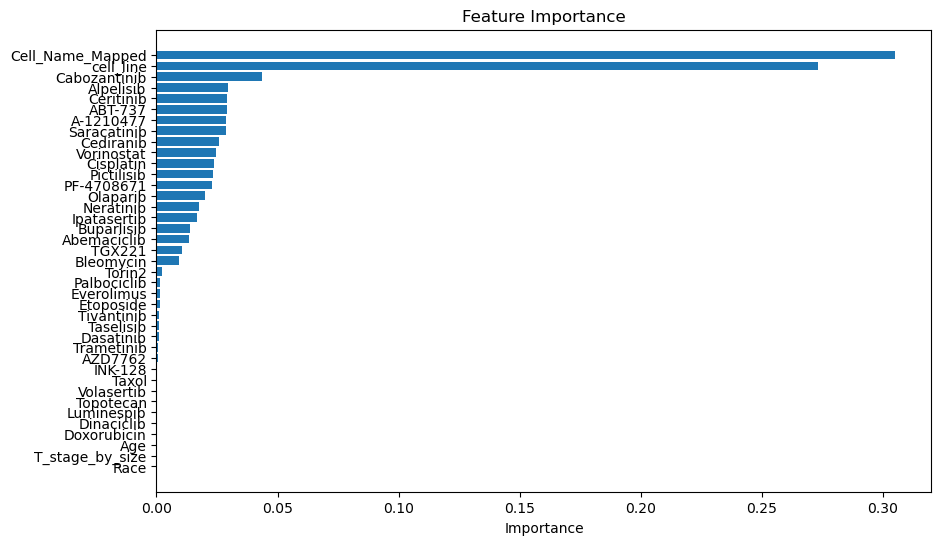

In [283]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


# LIMITATION NOTES TO EXPRESS TO AUDIENCE: 
### - We have only 1 IC50 value per cell line x drug. This means there is no variation in IC50 values per cell line x drug. This means demographic information has little affect on our results. 
### - CELL LINE IS A PROXY FOR THE PATIENT.
### - IF WE ASSUME THE CELL LINE REPRESENTS THE PATIENT, THEN PATIENT DEMOGRAPHICS ARE INFLUENCING THE IC50.
### - IC50 ACTS LIKE THE DOSAGE INFORMATION FOR THE PATIENT. 

### PERHAPS INCLUDE THE FOLLOWING FEATURES: BMI, MENOPAUSE STATUS

# NEW PATIENT TEST:

### - Note: Output does not change much with demographics, mainly just cell line:

In [295]:
# Create a template with all zero values
new_patient = pd.DataFrame(columns=X.columns)
new_patient.loc[0] = 0  # initialize all features with 0

# Fill in actual values for the patient
new_patient.at[0, 'Age'] = 90  # example age
new_patient.at[0, 'Race'] = 1  # assuming this is an integer-coded category
new_patient.at[0, 'cell_line'] = 10  # this should match a valid cell_line used during training

# Indicate which drug you're testing by setting the one-hot column to 1
new_patient.at[0, 'Buparlisib'] = 1  # for example

# Standardize Age using the same scaler used during training
new_patient[['Age']] = scaler.transform(new_patient[['Age']])

In [297]:
# List of non-drug columns and non-one-hot-encoded
non_drug_columns = ['Age', 'Race', 'cell_line', 'Patient ID', 'T_stage_by_size', 'Survival Months', 'Cell Name', 'Small Molecule Name', 'EC50 (uM)', 'Cell_Name_Mapped']

drug_columns = [col for col in X.columns if col not in non_drug_columns]


# Get drug columns by excluding non-drug columns
drug_columns = [col for col in X.columns if col not in non_drug_columns]
results = []

# Loop through each drug and make a prediction
for drug in drug_columns:
    temp_input = new_patient.copy()
    temp_input[drug] = 1
    try:
        ec50 = model.predict(temp_input)[0]
        results.append((drug, ec50))
    except Exception as e:
        print(f"Error predicting for {drug}: {e}")

# Sort drugs by predicted EC50 (lower is better)
results = sorted(results, key=lambda x: x[1])

# Display top 5 recommended drugs
Top_5 = []
for drug, ec50 in results[:5]:
    print(f'{drug}: predicted EC50 = {ec50:.4f} µM')
    Top_5.append(drug)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co

Olaparib: predicted EC50 = 0.4871 µM
Ipatasertib: predicted EC50 = 0.6492 µM
AZD7762: predicted EC50 = 1.2509 µM
Bleomycin: predicted EC50 = 1.2509 µM
Buparlisib: predicted EC50 = 1.2509 µM


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co

In [299]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from IPython.display import display, HTML

In [301]:
SmallMolecules = pd.read_csv("data/HarvardSmallMolecules.csv")

In [303]:
columns = ['Name', 'Molecular Mass', 'SMILES']
SmallMolecules = SmallMolecules[columns]

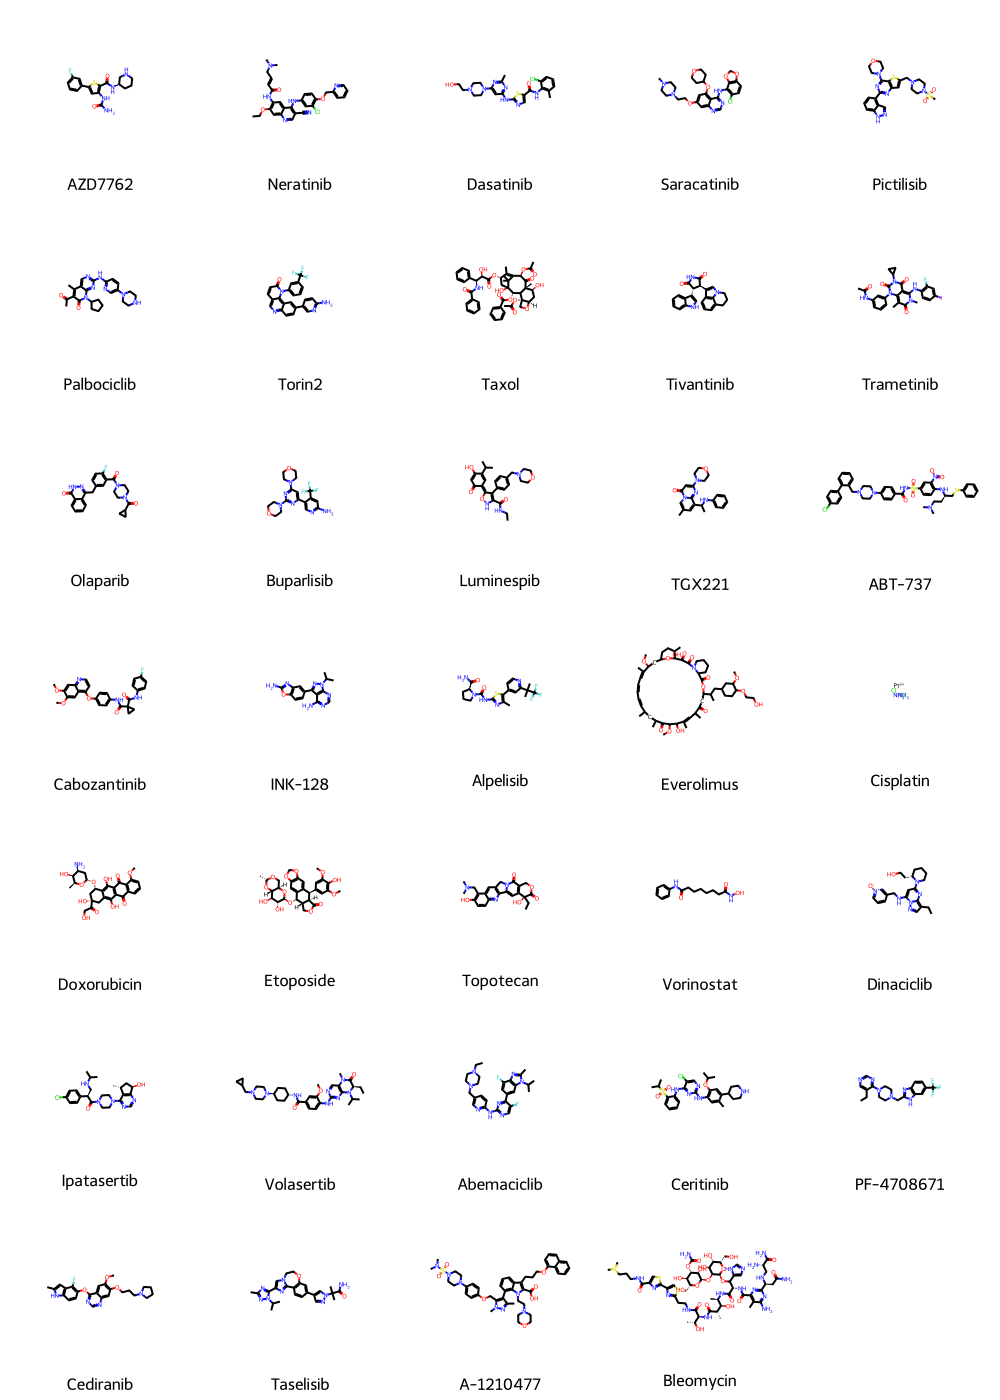

In [305]:
from rdkit import Chem
from rdkit.Chem import Draw

# Prepare molecules and names
mols = [Chem.MolFromSmiles(smiles) for smiles in SmallMolecules["SMILES"]]
names = SmallMolecules["Name"].tolist()

# Create image with names as legends
img = Draw.MolsToGridImage(
    mols,
    legends=names,
    molsPerRow=5,  # Adjust for layout, e.g. 5 columns x 7 rows
    subImgSize=(200,200)  # Size of each molecule image
)

# Show the image (in Jupyter)
from IPython.display import display
display(img)


In [307]:
SmallMolecules["Fingerprint"] = pd.Series(mols).apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=10, nBits=2048))

[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerator
[22:37:57] DEPRECATION WARNING: please use MorganGenerat

In [309]:
SmallMolecules["Mol"] = mols
SmallMolecules

,Name,Molecular Mass,SMILES,Fingerprint,Mol
0,AZD7762,362.12,C1C[C@H](CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1000>
1,Neratinib,556.20,CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=CC(=C(C=C3)OCC4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef17e0>
2,Dasatinib,487.16,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef18c0>
3,Saracatinib,541.21,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1930>
4,Pictilisib,513.16,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1b60>
5,Palbociclib,447.24,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1bd0>
6,Torin2,432.12,C1=CC(=CC(=C1)N2C(=O)C=CC3=CN=C4C=CC(=CC4=C32)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef19a0>
7,Taxol,853.33,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@](C3[...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1d20>
8,Tivantinib,369.15,C1CC2=CC=CC3=C2N(C1)C=C3[C@H]4[C@@H](C(=O)NC4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1c40>
9,Trametinib,615.08,CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1cb0>


In [311]:
# Select top 5 drugs recommended for test patient
subset = SmallMolecules[SmallMolecules["Name"].isin(Top_5)]
subset

,Name,Molecular Mass,SMILES,Fingerprint,Mol
0,AZD7762,362.12,C1C[C@H](CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1000>
10,Olaparib,434.18,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1e00>
11,Buparlisib,410.17,C1COCCN1C2=NC(=NC(=C2)C3=CN=C(C=C3C(F)(F)F)N)N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef1ee0>
25,Ipatasertib,457.22,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef2420>
33,Bleomycin,1414.52,CC1=C(N=C(N=C1N)[C@H](CC(=O)N)NC[C@@H](C(=O)N)...,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x39bef27a0>


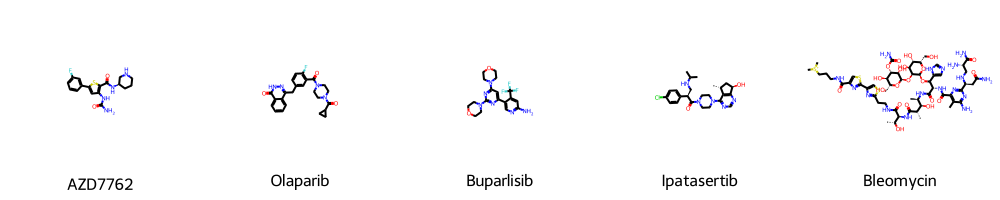

In [314]:
mol_list = subset["Mol"].tolist()
legends = subset["Name"].tolist()

img = Draw.MolsToGridImage(mol_list, molsPerRow=5, legends=legends, subImgSize=(200,200))
display(img)


In [316]:
from rdkit.DataStructs import TanimotoSimilarity

fps = SmallMolecules["Fingerprint"].tolist()
names = SmallMolecules["Name"].tolist()
n = len(fps)

# similarity matrix
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = TanimotoSimilarity(fps[i], fps[j])

# Convert to DataFrame for clarity
sim_df = pd.DataFrame(sim_matrix, index=names, columns=names)

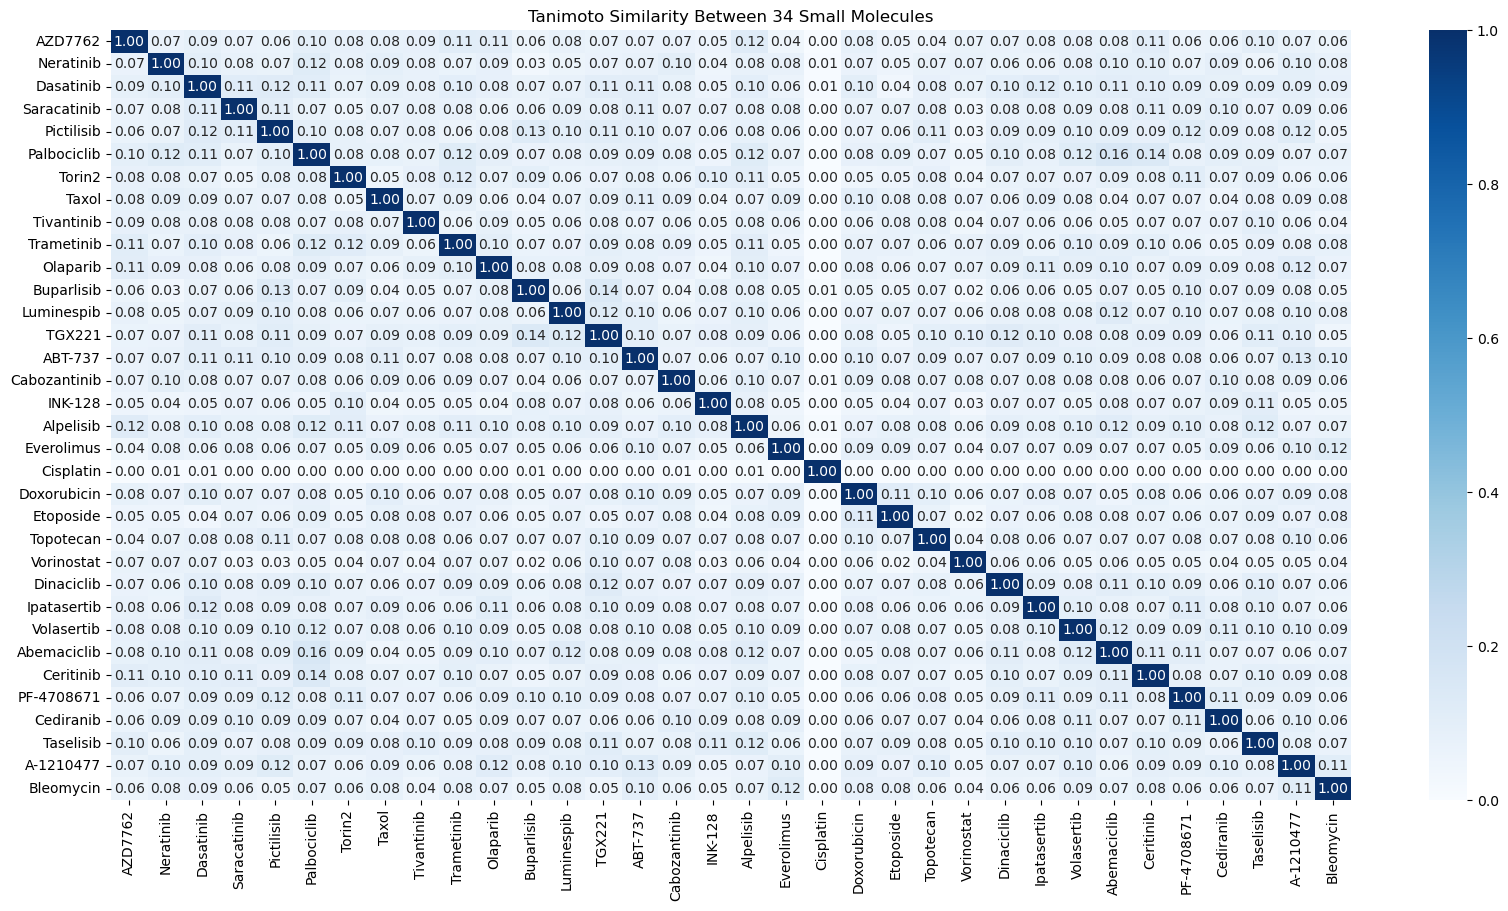

In [534]:
plt.figure(figsize=(20,10))
sns.heatmap(sim_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Tanimoto Similarity Between 34 Small Molecules")
plt.show()

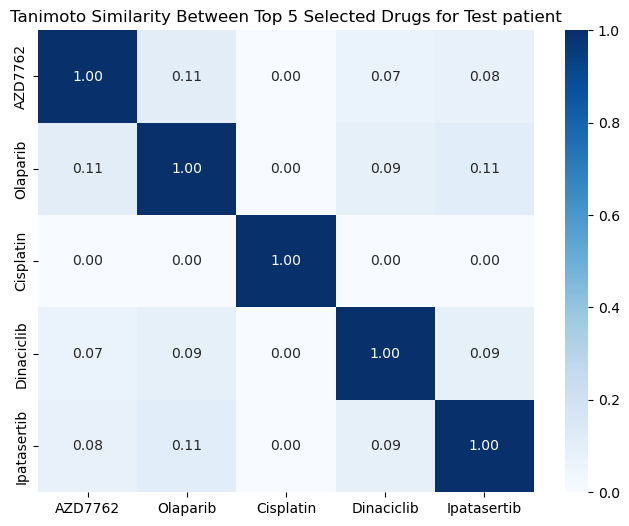

In [497]:
fps = subset["Fingerprint"].tolist()
names = subset["Name"].tolist()
n = len(fps)

# similarity matrix
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = TanimotoSimilarity(fps[i], fps[j])

# Convert to DataFrame for clarity
subset_sim_df = pd.DataFrame(sim_matrix, index=names, columns=names)

plt.figure(figsize=(8,6))
sns.heatmap(subset_sim_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Tanimoto Similarity Between Top 5 Selected Drugs for Test patient")
plt.show()

In [561]:
from rdkit.Chem import Crippen

# Calculate logP
SmallMolecules["logP"] = SmallMolecules["Mol"].apply(Crippen.MolLogP)


In [563]:
SmallMolecules

,Name,Molecular Mass,SMILES,Fingerprint,Mol,logp,logP
0,AZD7762,362.12,C1C[C@H](CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x392d267a0>,2.52660,2.52660
1,Neratinib,556.20,CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=CC(=C(C=C3)OCC4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x392d261f0>,5.93248,5.93248
2,Dasatinib,487.16,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a075a0>,3.31354,3.31354
3,Saracatinib,541.21,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04510>,3.93950,3.93950
4,Pictilisib,513.16,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04890>,2.14840,2.14840
5,Palbociclib,447.24,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04660>,2.96582,2.96582
6,Torin2,432.12,C1=CC(=CC(=C1)N2C(=O)C=CC3=CN=C4C=CC(=CC4=C32)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a047b0>,5.20190,5.20190
7,Taxol,853.33,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@](C3[...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04c10>,3.73570,3.73570
8,Tivantinib,369.15,C1CC2=CC=CC3=C2N(C1)C=C3[C@H]4[C@@H](C(=O)NC4=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04900>,3.59260,3.59260
9,Trametinib,615.08,CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x394a04740>,3.94012,3.94012


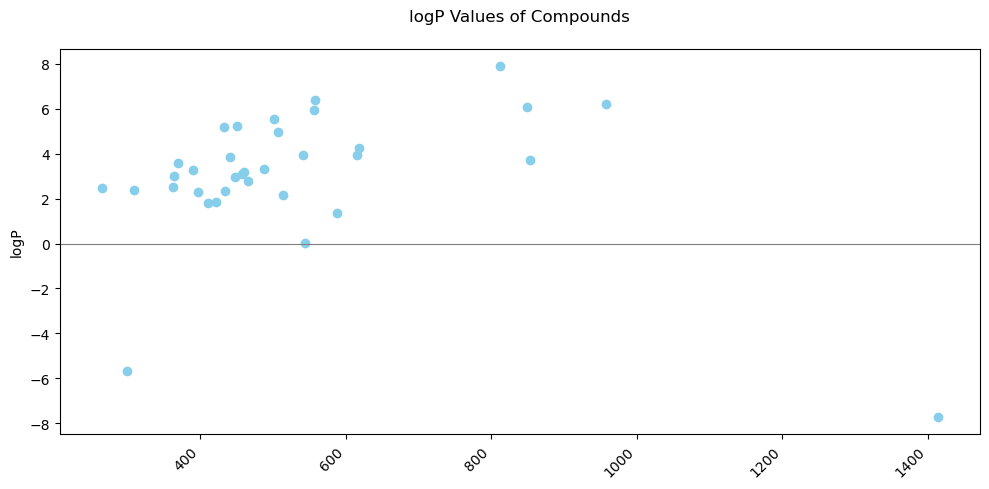

In [579]:
plt.figure(figsize=(10, 5))
bars = plt.scatter(SmallMolecules["Molecular Mass"], SmallMolecules["logP"], color='skyblue')

# Add horizontal line at 0
plt.axhline(0, color='gray', linewidth=0.8)

# Labels and title
plt.ylabel("logP")
plt.title("logP Values of Compounds", pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

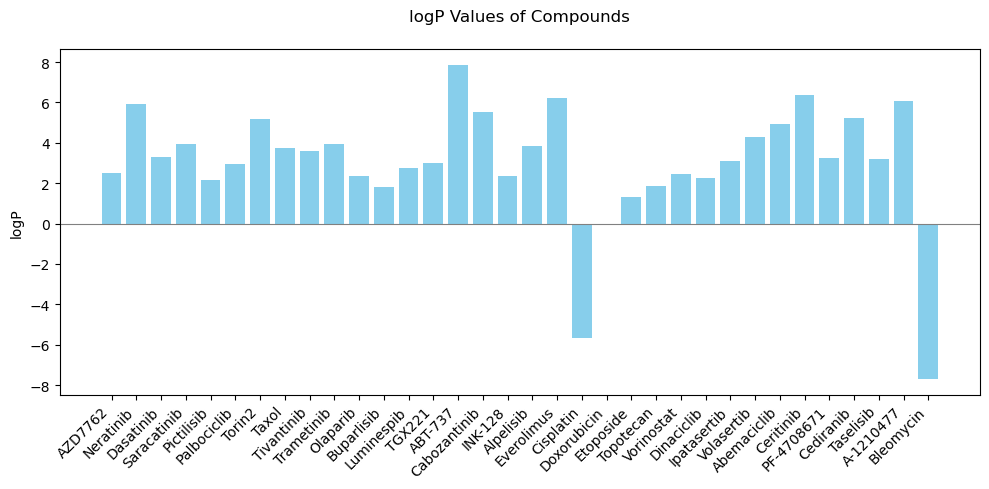

In [577]:
plt.figure(figsize=(10, 5))
bars = plt.bar(SmallMolecules["Name"], SmallMolecules["logP"], color='skyblue')

# Add horizontal line at 0
plt.axhline(0, color='gray', linewidth=0.8)

# Labels and title
plt.ylabel("logP")
plt.title("logP Values of Compounds", pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
